# Preprocessing

In [94]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import xgboost as xgb

import math

#Preprocessing

# load data
df = pd.read_csv('data.csv (1).zip')
df.head()

#Define preprocessor
# Fill sequencial data
def fillMedian(data):
    data = data.select_dtypes(exclude=['object'])
    cols = data.columns

    for col in cols:
        data[col].fillna(value=df[col].median(), inplace=True)
    return data

# Fill catogory data
def fillcat(data):
    data = data.select_dtypes(exclude=['float', 'int'])

    cols = data.columns
    one_hot_cols = []
    ord_cols = []

    for col in cols:
        data[col].fillna(value=data[col].mode, inplace=True)
        if len(data[col].unique()) < 10:
            one_hot_cols.append(col)
        else:
            ord_cols.append(col)
    
    label_transformer = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
        )
    one_hot_transformer = OrdinalEncoder(
        handle_unknown='ignore'
    )

    preprocessor =  ColumnTransformer(
        transformers=[
        ('num', label_transformer, ord_cols),
        ('cat', one_hot_transformer, one_hot_cols)
        ]
    )
   
    _data = preprocessor.fit_transform(data)
    return _data

X= df.drop(['Bankrupt?'], axis=1)
y= df['Bankrupt?']

num_transformer = FunctionTransformer(fillMedian)
cat_transsformer = FunctionTransformer(fillcat)
columns = X.columns

preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_transformer, columns),
    ('cat', cat_transsformer, columns),
    ]
)
X = preprocessor.fit_transform(X)

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, t_test = train_test_split(X, y, test_size=0.2)





# Build XGBoost model
class XGB():

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

# Define main metric


model = XGB() 
model.fit(X_train, y_train)
pred = model.predict(X_test)  


# Feature selection 

In [137]:
#feature selection
import scipy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler


def feature_selection(X, y, approach):
    sc = StandardScaler()
    sc.fit_transform(X)
    
    
    if approach == 'Basic approch':
        
        #obtain constain feature
        vt = VarianceThreshold(threshold = 0)
        vt.fit(X)
        
        drop_feature = []
        constant_col = vt.get_support()
        for i ,feature in enumerate(X.columns):
            if constant_col[i] == False:
                drop_feature.append(feature)
        print('Constant Featuer={}'.format(drop_feature))
         
        # obtain duplicate featuere
        X_T = X.T
        duplicate_feature = X_T[X_T.duplicated()].index.values
        print('Duplicate feature:{}'.format(duplicate_feature))
        
        for i in duplicate_feature:
            drop_feature.append(i)
        
        X.drop(drop_feature, axis=1, inplace=True)
        
        return X.columns
        
        
    elif approach == 'MI approch':
        score = mutual_info_classif(X, y, discrete_features='auto', random_state=0)
        sorted_idx = np.argsort(score)[::-1]

        top10_score = sorted_idx[:10]
        top10_feature = X.columns[sorted_idx][:10]
         
        X = X[top10_feature]
        
        for i in range(10):
            print('{} = {}'.format(top10_feature[i], score[sorted_idx[i]]))
        
        return X.columns
        
    elif approach == 'VIF approch':
        pass
    
    
    
    

X= df.drop(['Bankrupt?'], axis=1)
y= df['Bankrupt?']
selected_feature = feature_selection(X,y,'MI approch')
    
    


 Persistent EPS in the Last Four Seasons = 0.04098391964488224
 Net Income to Stockholder's Equity = 0.040482799213047205
 Net profit before tax/Paid-in capital = 0.039178711208919914
 Borrowing dependency = 0.0387741161968731
 Per Share Net profit before tax (Yuan ¥) = 0.038476598534215034
 Net Income to Total Assets = 0.036738039726433414
 ROA(A) before interest and % after tax = 0.03633483744690702
 Interest Expense Ratio = 0.035252383569137624
 Debt ratio % = 0.03493144622709643
 Net worth/Assets = 0.03479391058675052


In [139]:
X[selected_feature]

,Persistent EPS in the Last Four Seasons,Net Income to Stockholder's Equity,Net profit before tax/Paid-in capital,Borrowing dependency,Per Share Net profit before tax (Yuan ¥),Net Income to Total Assets,ROA(A) before interest and % after tax,Interest Expense Ratio,Debt ratio %,Net worth/Assets
0,0.169141,0.827890,0.137757,0.390284,0.138736,0.716845,0.424389,0.629951,0.207576,0.792424
1,0.208944,0.839969,0.168962,0.376760,0.169918,0.795297,0.538214,0.635172,0.171176,0.828824
2,0.180581,0.836774,0.148036,0.379093,0.142803,0.774670,0.499019,0.629631,0.207516,0.792484
3,0.193722,0.834697,0.147561,0.379743,0.148603,0.739555,0.451265,0.630228,0.151465,0.848535
4,0.212537,0.839973,0.167461,0.375025,0.168412,0.795016,0.538432,0.636055,0.106509,0.893491
...,...,...,...,...,...,...,...,...,...,...
6814,0.216602,0.840359,0.171111,0.373823,0.172102,0.799927,0.539468,0.631415,0.124618,0.875382
6815,0.216697,0.840306,0.171805,0.372505,0.172780,0.799748,0.538269,0.631489,0.099253,0.900747
6816,0.210929,0.840138,0.172287,0.369637,0.173232,0.797778,0.533744,0.630612,0.038939,0.961061
6817,0.228326,0.841084,0.182498,0.369649,0.185584,0.811808,0.559911,0.630731,0.086979,0.913021


# Data visualization

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

#plt.style.use('ggpplot')
rcParams['figure.figsize'] = (12,6)

target = df['Bankrupt?'].astype('str')
target

0       1
1       1
2       1
3       1
4       1
       ..
6814    0
6815    0
6816    0
6817    0
6818    0
Name: Bankrupt?, Length: 6819, dtype: object

In [206]:
def data_visualization(X, y, method):
    
    
    num_columns = X.select_dtypes(['int', 'float']).columns
    cat_columns = X.select_dtypes('object').columns
    
    n_col = 2
    n_row = math.ceil(len(num_columns)/n_col)
    
    if method == 'boxenplot':
    
        sns.set_style('darkgrid')
        fig, axes = plt.subplots(n_row, n_col)
        axes = axes.ravel()
        for i, col in enumerate(num_columns):
            sns.boxenplot(X[col], ax=axes[i])
        plt.tight_layout()
        plt.show()
       
    
    elif method == 'hist':
        
        fig, axes = plt.subplots(n_row, n_col)
        axes = axes.ravel()
        for i, col in enumerate(num_columns):
            sns.histplot(x=X[col], ax=axes[i])
        plt.tight_layout()
        plt.show()
        
    elif method == 'scatter':
        
        fig, axes = plt.subplots(n_row, n_col)
        axes = axes.ravel()
        for i, col in enumerate(num_columns):
            print(col)
            sns.scatterplot(X[col], y, ax=axes[i])
        plt.tight_layout()
        plt.show()
       
        
    elif method == 'correlation_matrix':
        
        data = X
        data['target'] = y
        corr = data.corr()
        sns.heatmap(corr)
        plt.show()

 Persistent EPS in the Last Four Seasons
 Net Income to Stockholder's Equity
 Net profit before tax/Paid-in capital
 Borrowing dependency
 Per Share Net profit before tax (Yuan ¥)
 Net Income to Total Assets
 ROA(A) before interest and % after tax
 Interest Expense Ratio
 Debt ratio %
 Net worth/Assets


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

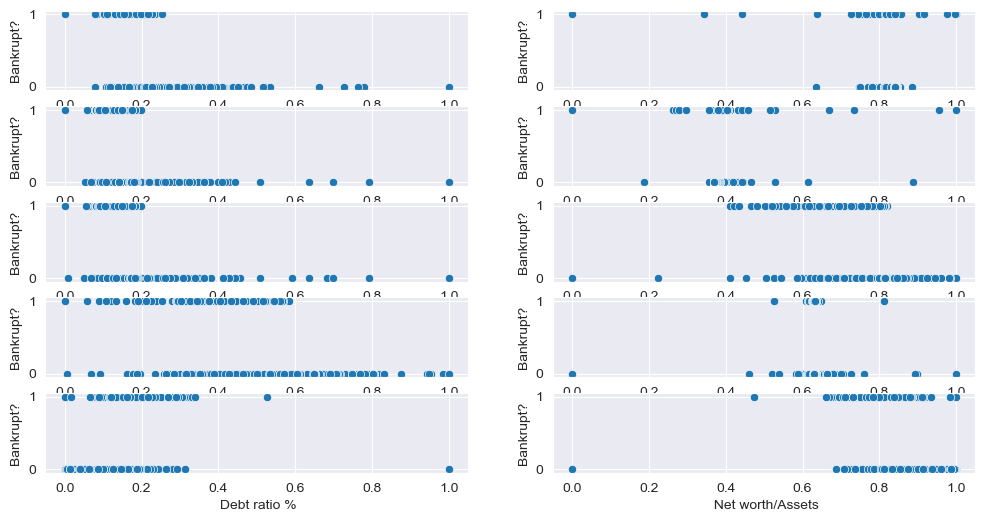

In [200]:
X= df.drop(['Bankrupt?'], axis=1)
X = X[selected_feature]
y= df['Bankrupt?']

data_visualization(X,y, 'scatter')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/si

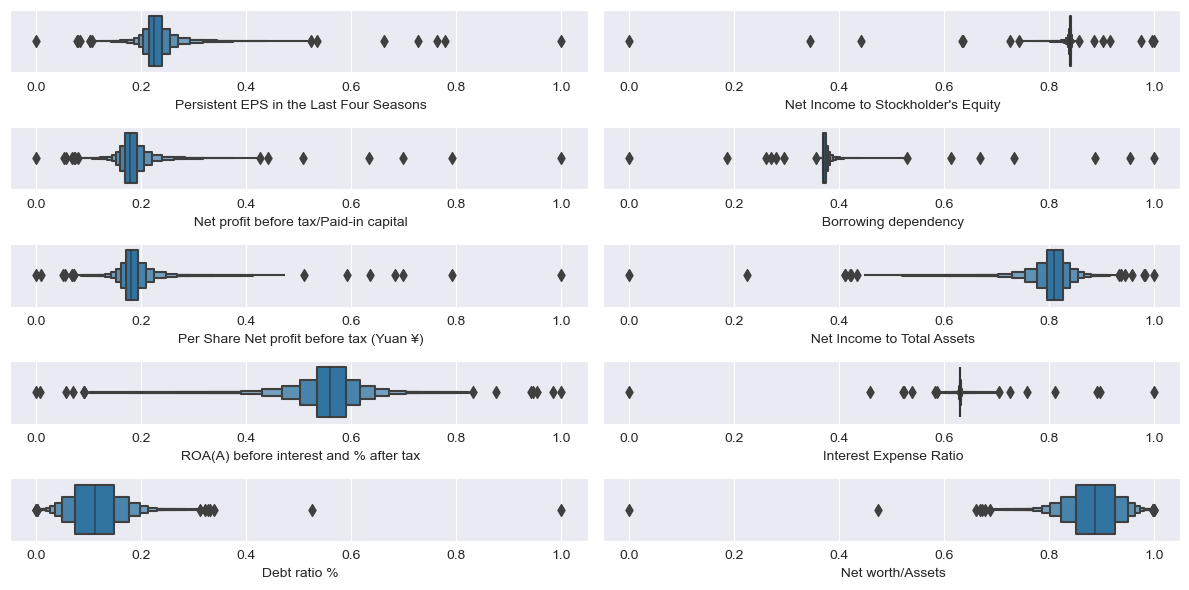

In [201]:
data_visualization(X,y, 'boxenplot')

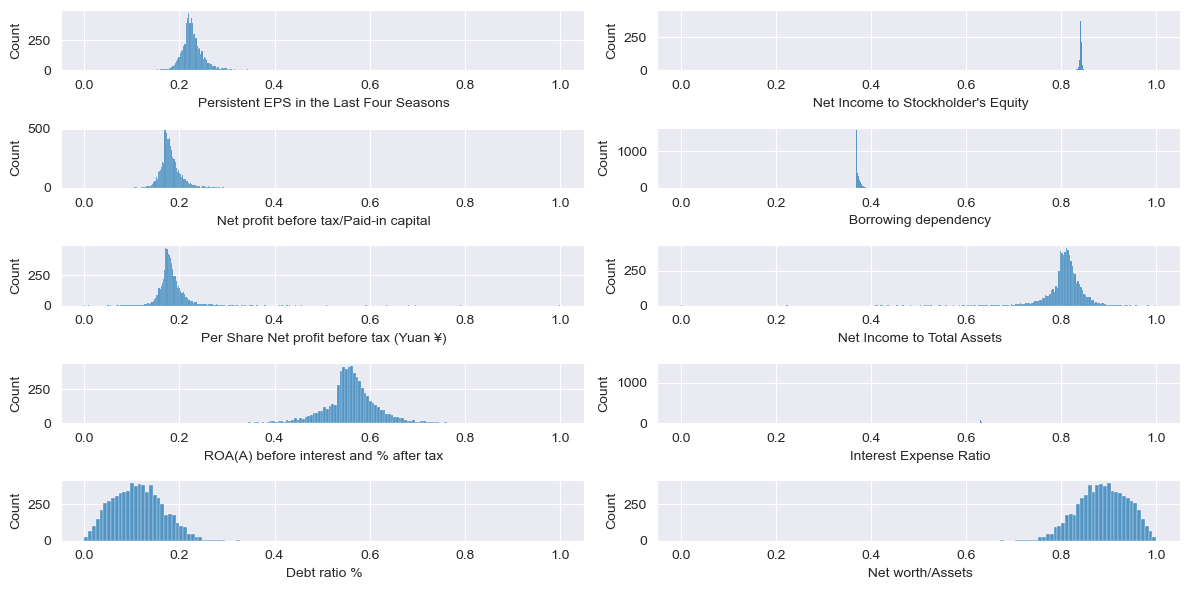

In [202]:
data_visualization(X,y, 'hist')

 Persistent EPS in the Last Four Seasons
 Net Income to Stockholder's Equity
 Net profit before tax/Paid-in capital
 Borrowing dependency
 Per Share Net profit before tax (Yuan ¥)
 Net Income to Total Assets
 ROA(A) before interest and % after tax
 Interest Expense Ratio
 Debt ratio %
 Net worth/Assets


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

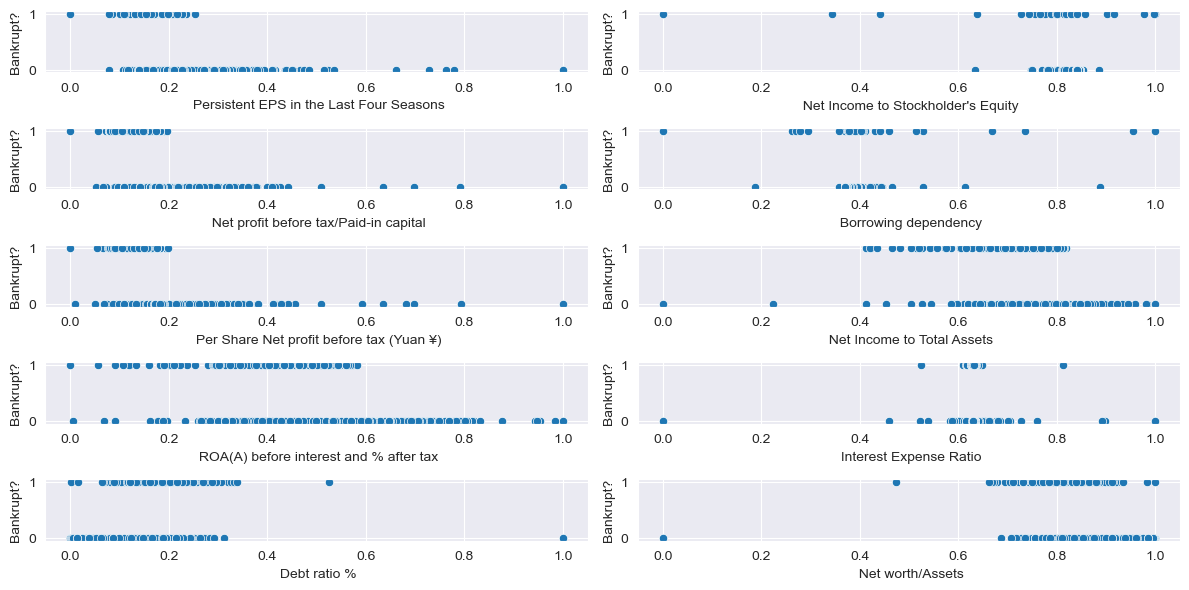

In [204]:
data_visualization(X,y, 'scatter')

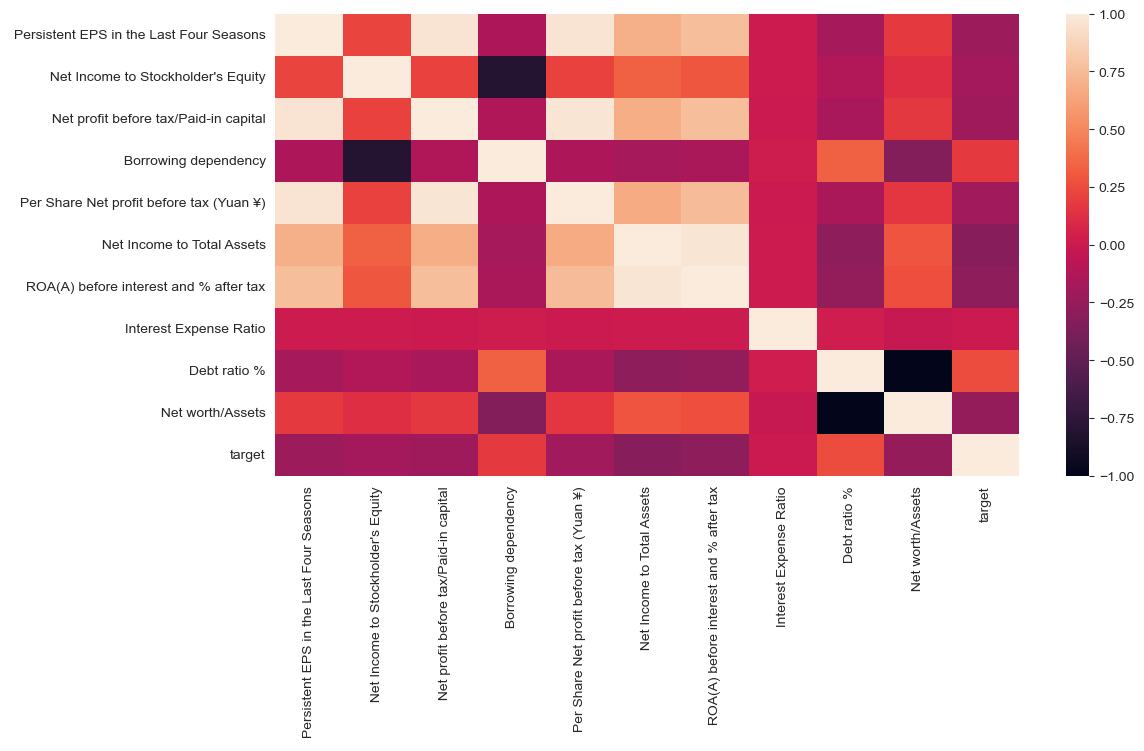

In [207]:
data_visualization(X,y, 'correlation_matrix')